# Imports

In [24]:
import numpy as np
from numpy import log as ln, exp
from scipy import stats
from scipy.optimize import fsolve
from matplotlib import pyplot as plot
import matplotlib
import os
from matplotlib.patches import Rectangle

matplotlib.rcParams["figure.dpi"] = 300
os.environ["PATH"] += os.pathsep + """/usr/local/texlive/2023/bin/
                                      universal-darwin"""
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rc("font", family="STIXGeneral") 
matplotlib.rc("font", weight="ultralight")

# Calculating free energies and critical concentrations

In [25]:
def dG_from_CMC(m_CMC, N):
    return -ln(m_CMC**(1-N) / N)


def dg_from_CMC(m_CMC, N):
    return dG_from_CMC(m_CMC, N) / N


def dG_from_K(K):
    return -ln(K)

    
def dg_from_K(K, N):
    return dG_from_K(K) / N


def K_from_dG(dG):
    return exp(-dG)


def CMC_from_K(K, N):
    return (N * K)**(-1/(N-1))


def CMC_from_dG(dG, N):
    return (N * K_from_dG(dG))**(-1/(N-1))


# General CMC range.
print("dG trimers",
      round(dG_from_CMC(10*10**(-6), 3)),
      round(dG_from_CMC(100*10**(-6), 3)))
print("dG tetramers",
      round(dG_from_CMC(10*10**(-6), 4)),
      round(dG_from_CMC(100*10**(-6), 4)))
print("dg trimers",
      round(dg_from_CMC(10*10**(-6), 3)),
      round(dg_from_CMC(10*10**(-6), 3) - ln(10*10**(-6))),
      round(dg_from_CMC(100*10**(-6), 3)),
      round(dg_from_CMC(100*10**(-6), 3) - ln(100 * 10**(-6))))
print("dg tetramers",
      round(dg_from_CMC(10*10**(-6), 4)),
      round(dg_from_CMC(10*10**(-6), 4) - ln(10*10**(-6))),
      round(dg_from_CMC(100*10**(-6), 4)),
      round(dg_from_CMC(100*10**(-6), 4) - ln(100 * 10**(-6))))

# Glucagon [Gratzer 1969].
print("glucagon")
K_2 = 1.5 * 10**3
K_3 = 2.5 * 10**6
K_6 = 6 * 10**16
print("CMCs",
      round(CMC_from_K(K_2, 2) * 10**6),
      round(CMC_from_K(K_3, 3) * 10**6),
      round(CMC_from_K(K_6, 6) * 10**6))

# Insulin [Goldman 1974].
print("insulin")
K_12 = 2.22 * 10**5
K_24 = 40
K_46 = 220
K_16 = K_12**3 * K_24 * K_46
dG_hexa, dg_hexa = dG_from_K(K_16), dg_from_K(K_16, 6)
print("dG hexamer", round(dG_hexa))
print("dg hexamer", round(dg_hexa))
print("CMC", round(CMC_from_dG(dG_hexa, 6) * 10**6))

dG trimers -22 -17
dG tetramers -33 -26
dg trimers -7 4 -6 3
dg tetramers -8 3 -7 3
glucagon
CMCs 333 365 308
insulin
dG hexamer -46
dg hexamer -8
CMC 70


# Theoretical plots of regime changes due to CMCs and critical ratios

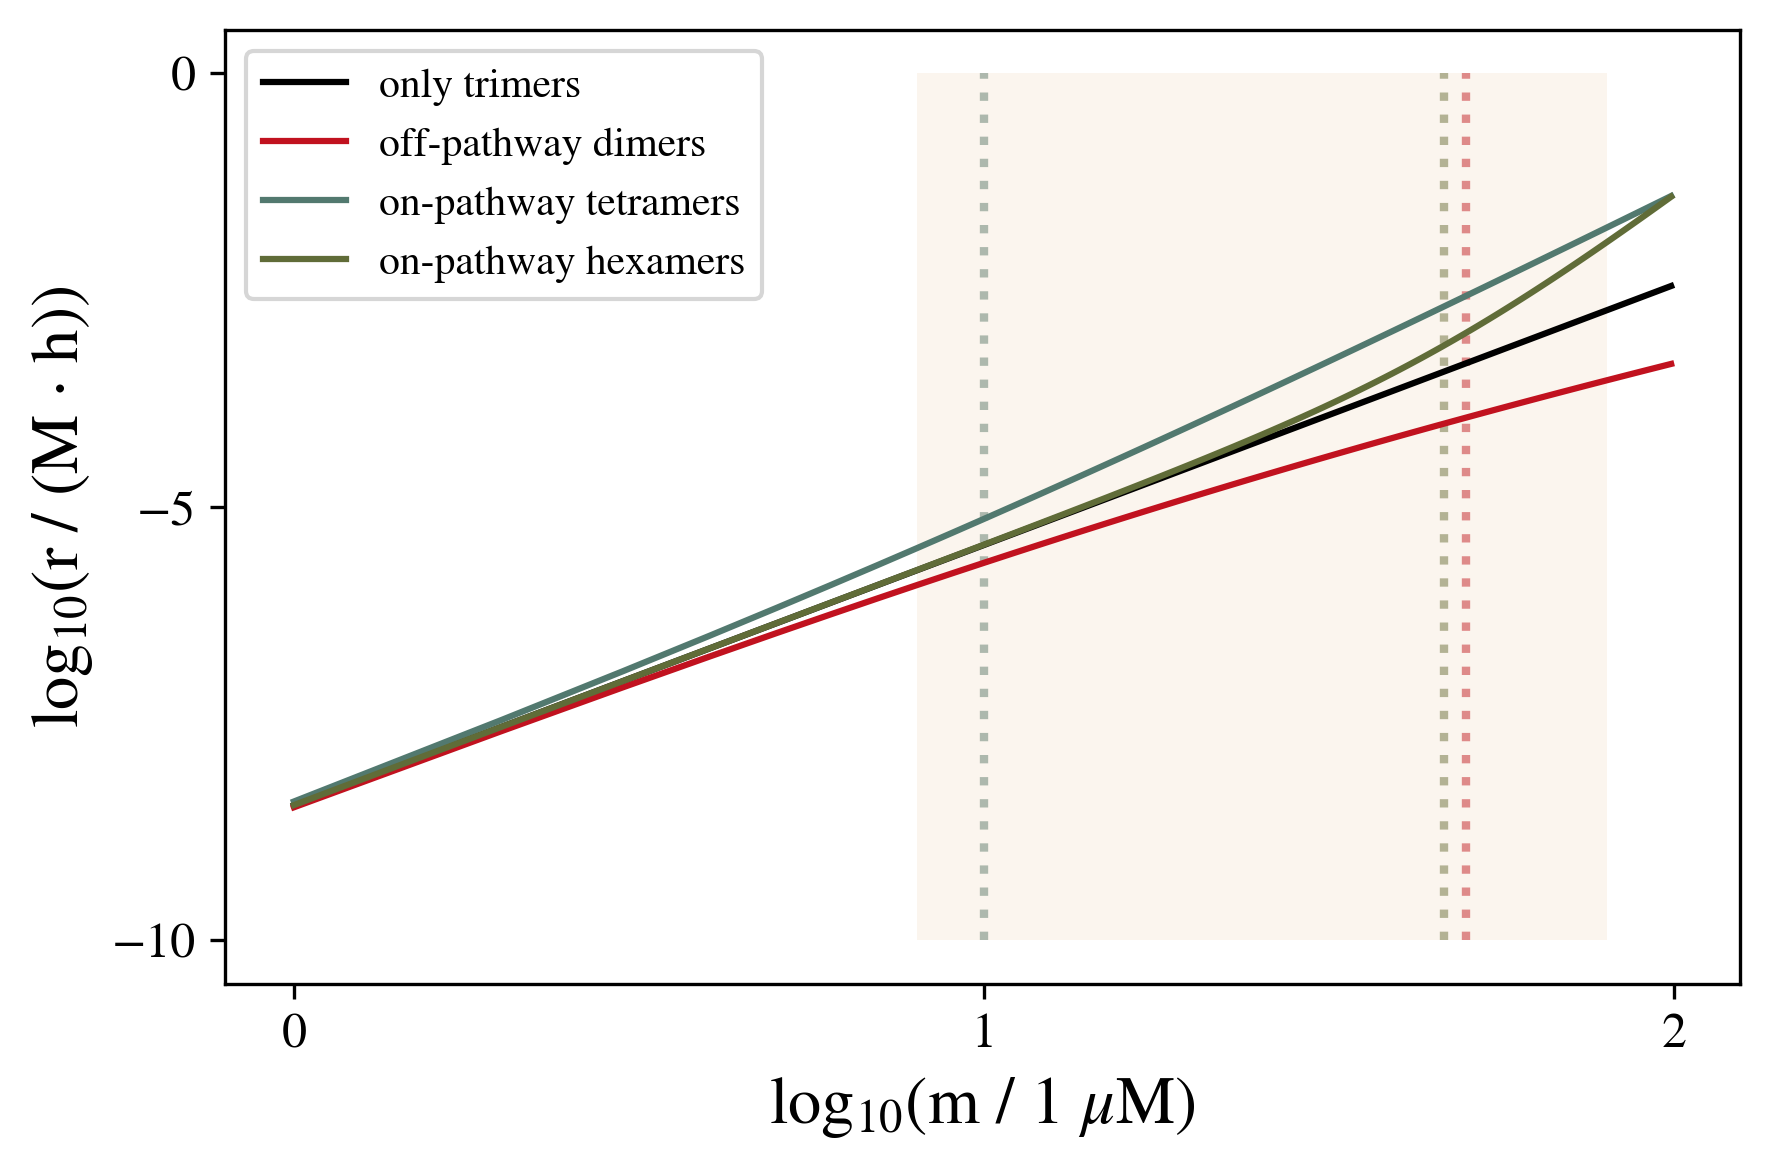

In [26]:
def draw_series(N_off, K_off, N_on_list, K_on_list, k_on_list, label, color):
    """Draw theoretical dependence of primary nucleation rate
       on total monomer concentration.
    
    Parameters
    ----------
        N_off : int or None
            Size of off-pathway oligomers.
            None, if no off-pathway.
        K_off : float or None
            Association equilibrium constant of off-pathway oligomers.
            None, if no off-pathway.
        N_on_list : list
            List of on-pathway oligomer sizes.
        K_on_list : list
            List of on-pathway oligomer association equilibrium constants.
        k_on_list : list
            List of on-pathway oligomer association rate constants.
        label : str
            Name of the series.
        color : str
            Color of the curve.
    """
    

    def f(m_free):
        """Equation on concentration of free monomers.
        
        Parameters
        ----------
            m_free : float
                Concentration of the free monomers
                to check in the equation.
        
        Returns
        -------
            Precision of the solution.
        """

        return K_off * m_free**N_off + m_free / N_off - m / N_off


    r_list, m_free_list = [], []

    for m in m_arr:
        if N_off is not None:
            m_free = fsolve(f, m / 2)
        else:
            m_free = m
        m_free_list.append(m_free)
        
        r = 0
        num_on = len(N_on_list)
        for i in range(num_on):
            r += k_on_list[i] * K_on_list[i] * m_free**N_on_list[i]
        
        r_list.append(r)

    ln_m_arr = ln(m_arr * 10**6).flatten() / ln(10)
    ln_r_arr = ln(np.array(r_list) * 60 * 60 / m).flatten() / ln(10)
    
    if N_off is not None:
        CMC_off = CMC_from_K(K_off, N_off) * 10**6
        plot.vlines(x=np.log(CMC_off) / np.log(10), ymin=-10, ymax=0, linestyle="dotted",
                    zorder=-2, linewidth=2, color=color, alpha=0.5)

    if num_on > 1:
        CMC_on = (k_on_list[0] * K_on_list[0] / k_on_list[1] / K_on_list[1])**\
                 (1/(N_on_list[1] - N_on_list[0])) * 10**6
        plot.vlines(x=np.log(CMC_on) / np.log(10), ymin=-10, ymax=0, linestyle="dotted",
                    zorder=-2, linewidth=2, color=color, alpha=0.5)

    plot.plot(ln_m_arr, ln_r_arr, label=label, color=color)

    regr_1 = stats.linregress(ln_m_arr[:10], ln_r_arr[:10])
    regr_2 = stats.linregress(ln_m_arr[50:], ln_r_arr[50:])
    slope_1, slope_2 = regr_1.slope, regr_2.slope
    #print("eff nucl 1", round(get_N_crit(slope_1), 2))
    #print("eff nucl 2", round(get_N_crit(slope_2), 2))


fig, ax = plot.subplots()
m_arr = np.arange(1*10**(-6), 100*10**(-6), 1*10**(-6))    

draw_series(None, None, [3], [10**6], [10**(-4)],
            "only trimers", "black")
draw_series(2, 10**4, [3], [10**6], [10**(-4)],
            "off-pathway dimers", "#c1121f")
draw_series(None, None, [3, 4], [10**6, 10**8], [10**(-4), 10**(-1)],
            "on-pathway tetramers", "#52796f")
draw_series(None, None, [3, 6], [10**6, 10**16], [10**(-4), 10**(-1)],
            "on-pathway hexamers", "#606c38")

ax.add_patch(Rectangle((np.log(8) / np.log(10), -10),
                       (np.log(500) - np.log(50)) / np.log(10), 10,
                        fc="#dda15e", 
                        lw=0, alpha=0.1, zorder=-1))

plot.xlabel(r"log$_{10}$(m / 1 $\mu$M)", fontsize=16)
plot.ylabel(r"log$_{10}$(r / (M $\cdot$ h))", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=4)
plot.legend(loc="upper left")
plot.tight_layout()
plot.savefig("fig/th_m_t_lag.png")
plot.show()

# Kinetic lag time approximations

In [36]:
def calculate_regime_series(fig_kin_name=None, fig_slope_name=None, N_th_dict=dict()):

    def calc(m):
        A = N * k_N * K_N * m**N
        B = s * k_sec * K_sec * m**s
        C = k_grow * (m / K_cap)**(1/c)
        D = 2 * k_frag

        Delta = B**2 + 4 * B * C / s
        ev_1 = (B + Delta**(1/2)) / 2
        ev_2 = (B - Delta**(1/2)) / 2

        x_p = - A * s / B / N

        def x(t):
            return x_p + A / (ev_1 - ev_2) * \
                ((ev_1 + C / N) / ev_1 * exp(ev_1 * t) - \
                 (ev_2 + C / N) / ev_2 * exp(ev_2 * t))

        def x_frag(t):
            x_p = A * s * (C - D * N) / (B * N * (s * D - C))
            y_p = A * (N - s) / (N * (s * D - C))
            Delta = (B - D)**2 + 4 * B * C / s
            ev_1 = (B + D + Delta**(1/2)) / 2
            ev_2 = (B + D - Delta**(1/2)) / 2
            k_1 = (ev_1 - B) / C
            k_2 = (ev_2 - B) / C

            return x_p + ((A + ev_2 * x_p) * exp(ev_1 * t) - \
                          (A + ev_1 * x_p) * exp(ev_2 * t)) / (ev_1 - ev_2)

        def x_approx(t):
            poly_1 = ev_1 * t + ev_1**2 / 2 * t**2
            poly_2 = ev_2 * t + ev_2**2 / 2 * t**2
            return A * (t + 0.5 * (B + C / N) * t**2)

        def x_approx_frag(t):
            x_p = A * s * (C - D * N) / (B * N * (s * D - C))
            y_p = A * (N - s) / (N * (s * D - C))
            Delta = (B - D)**2 + 4 * B * C / s
            ev_1 = (B + D + Delta**(1/2)) / 2
            ev_2 = (B + D - Delta**(1/2)) / 2
            k_1 = (ev_1 - B) / C
            k_2 = (ev_2 - B) / C

            return x_p + ((A + ev_2 * x_p) * exp(ev_1 * t) - \
                          (A + ev_1 * x_p) * exp(ev_2 * t)) / (ev_1 - ev_2)

        t_arr = np.arange(0, T, T / num_t)
        x_list, x_approx_list = [], []

        lag_flag, lag_flag_approx = True, True
        for t in t_arr:
            x_t = x_frag(t)
            x_list.append(x_t)

            if lag_flag and x_t > alpha * m:
                t_lag = t
                lag_flag = False

            x_approx_t = x_approx_frag(t)
            x_approx_list.append(x_approx_t)

            if lag_flag_approx and x_approx_t > alpha * m:
                t_lag_approx = t
                lag_flag_approx = False

        if plot_kinetics:
            ax_dict[N].set_title("N = " + str(N), fontsize=16)
            ax_dict[N].plot(t_arr / 60 / 60, np.array(x_approx_list) / m * 100,
                            linewidth=4, color="#606c38")
            ax_dict[N].plot(t_arr / 60 / 60, np.array(x_list) / m * 100,
                            linewidth=4, color=m_color_dict[m], label=str(round(m * 10**6)) + r" $\mu$M")

        return t_lag, t_lag_approx

    def quad_eq_sol(m):
        A = N * k_N * K_N * m**N
        B = s * k_sec * K_sec * m**s
        C = k_grow * (m / K_cap)**(1/c)
        return (-1 + (1 + 2 * (B + C / N) * alpha * m / A)**(1/2)) / (B + C / N)
    
    if plot_kinetics:
        #fig, ((ax_1, ax_2), (ax_3, ax_4), (ax_5, ax_6)) = plot.subplots(3, 2)
        fig, ax_2 = plot.subplots()
        ax_dict = {
            #1: ax_1,
            2: ax_2,
            #3: ax_3,
            #4: ax_4,
            #5: ax_5,
            #6: ax_6
        }

    for N in N_list:
        K_N = 10**(4*(N-1))

        th_m_list, th_t_list = [], []
        for m in np.arange(10*10**(-6), 1000*10**(-6), 10**(-6)):
            th_m_list.append(m)
            th_t_list.append(quad_eq_sol(m))

        ln_th_m_list = ln(np.array(th_m_list) * 10**6) / ln(10)
        ln_th_t_list = ln(np.array(th_t_list) / 60 / 60) / ln(10)

        #plot.plot(ln_th_m_list, ln_th_t_list, color="black")
        #plot.tight_layout()
        #plot.show()

        regr = stats.linregress(ln_th_m_list, ln_th_t_list)
        print("R^2", round(regr.rvalue**2, 2))
        slope, intercept = regr.slope, regr.intercept

        m_list = [100*10**(-6), 150*10**(-6), 200*10**(-6), 250*10**(-6), 300*10**(-6)]
        t_lag_list, t_lag_approx_list = [], []
        for m in m_list:
            t_lag, t_lag_approx = calc(m)
            t_lag_list.append(t_lag)
            t_lag_approx_list.append(t_lag_approx)

        if plot_kinetics:
            #plot.hlines(y=alpha * 100, xmin=0, xmax=T / 60 / 60, color="black", alpha=0.5)
            #plot.xticks(fontsize=16)
            #plot.yticks(fontsize=16)
            #if N == 5:
            if N == 2:
                #ax_dict[N].set_xlabel("t, h")
                #ax_dict[N].set_ylabel("Conversion, %")
                ax_dict[N].set_xlabel("t, h", fontsize=16)
                ax_dict[N].set_ylabel("Conversion, %", fontsize=16)
            ax_dict[N].set_xlim(xmin=0, xmax=max(t_lag_list) / 60 / 60)
            ax_dict[N].set_ylim(ymin=0, ymax=alpha * 100)
            #plot.legend()
            #plot.tight_layout()
            #plot.show()

        ln_m_arr = ln(np.array(m_list) * 10**6) / ln(10)
        ln_t_lag_arr = ln(np.array(t_lag_list) / 60 / 60) / ln(10)
        ln_t_lag_approx_arr = ln(np.array(t_lag_approx_list) / 60 / 60) / ln(10)
        #plot.scatter(ln_m_arr, ln_t_lag_arr,
        #             color="none", edgecolor="black", linewidth=2, s=128)
        if plot_slopes:
            plot.scatter(ln_m_arr, ln_t_lag_approx_arr,
                         color="none", edgecolor=N_color_list[N-2],
                         linewidth=2, s=128, label="N = " + str(N))
            plot.xticks(fontsize=16)
            plot.yticks(fontsize=16)
            plot.xlabel(r"log$_{10}$(m / 1 $\mu$M)", fontsize=16)
            plot.ylabel(r"log$_{10}$(t$_{lag}$ / 1 h)", fontsize=16)

        regr = stats.linregress(ln_m_arr, ln_t_lag_arr)
        print("R^2 precise", round(regr.rvalue**2, 2))
        slope, intercept = regr.slope, regr.intercept
        if plot_slopes:
            plot.plot(ln_m_arr, ln_m_arr * slope + intercept, color=N_color_list[N-2])
        N_th_dict[N] = get_N_elong_cap(slope, 1)

        print("N", N)
        print("slope", round(slope, 2))
        print("N_th", round(N_th_dict[N], 2))
        print("lag times precise", np.array(t_lag_list) / 60 / 60)
        print("lag time approx", np.array(t_lag_approx_list) / 60 / 60)

    if plot_kinetics:
        plot.xticks(fontsize=16)
        plot.yticks(fontsize=16)
        plot.legend()
        plot.tight_layout()
        plot.savefig("fig/" + fig_kin_name + ".png")
        plot.show()

    if plot_slopes:
        plot.legend()
        plot.tight_layout()
        plot.savefig("fig/" + fig_slope_name + ".png")
        plot.show()


# plot lag times versus concentrations in double log
plot_slopes = True
# plot kinetical curves
plot_kinetics = False
# number of timestamps
num_t = 10000

# sizes of primary nuclei, calculations will be performed for each one
#N_list = [2]  # for slopes plotting
N_list = [1, 2, 3, 4, 5, 6]  # for kinetics plotting
# corresponding colors to distinguish series with different nuclei sizes
N_color_list = ["#52b788", "#40916c", "#2d6a4f", "#1b4332", "#081c15"]
# colors for concentrations
m_color_dict = {
    100*10**(-6): "#ad2831",
    150*10**(-6): "#800e13",
    200*10**(-6): "#640d14",
    250*10**(-6): "#38040e",
    300*10**(-6): "#250902"
}

# conversion threshold to define the lag time
alpha = 0.01
# size of the secondary nuclei
s = 2
# conversion rate constant of transient N-mers [1 / s]
k_N = 10**(-9)
# conversion rate constant of secondary oligomers [1 / s]
k_sec = 10**(-4)
# association equilibrium constant of secondary oligomers [1 / M^s]
K_sec = 10**3
# fibril elongation rate constant
k_grow = 10**1
# maximal time [s]
T = 60 * 60 * 40

# Elongation regime

R^2 1.0
R^2 precise 1.0
N 1
slope -0.5
N_th 1.5
lag times precise [38.976 31.828 27.544 24.604 22.416]
lag time approx [38.976 31.828 27.544 24.604 22.416]
R^2 1.0
R^2 precise 1.0
N 2
slope -1.0
N_th 2.0
lag times precise [38.7   25.788 19.332 15.46  12.88 ]
lag time approx [38.7   25.788 19.332 15.46  12.88 ]
R^2 1.0
R^2 precise 1.0
N 3
slope -1.51
N_th 3.03
lag times precise [38.428 20.82  13.468  9.604  7.284]
lag time approx [38.428 20.82  13.468  9.604  7.284]
R^2 1.0
R^2 precise 1.0
N 4
slope -2.05
N_th 4.1
lag times precise [38.156 16.724  9.28   5.856  4.012]
lag time approx [38.156 16.724  9.28   5.856  4.012]
R^2 1.0
R^2 precise 1.0
N 5
slope -2.63
N_th 5.26
lag times precise [37.888 13.356  6.284  3.46   2.1  ]
lag time approx [37.888 13.356  6.284  3.46   2.1  ]
R^2 0.99
R^2 precise 1.0
N 6
slope -3.29
N_th 6.58
lag times precise [37.62  10.58   4.148  1.936  1.004]
lag time approx [37.62  10.58   4.148  1.936  1.004]


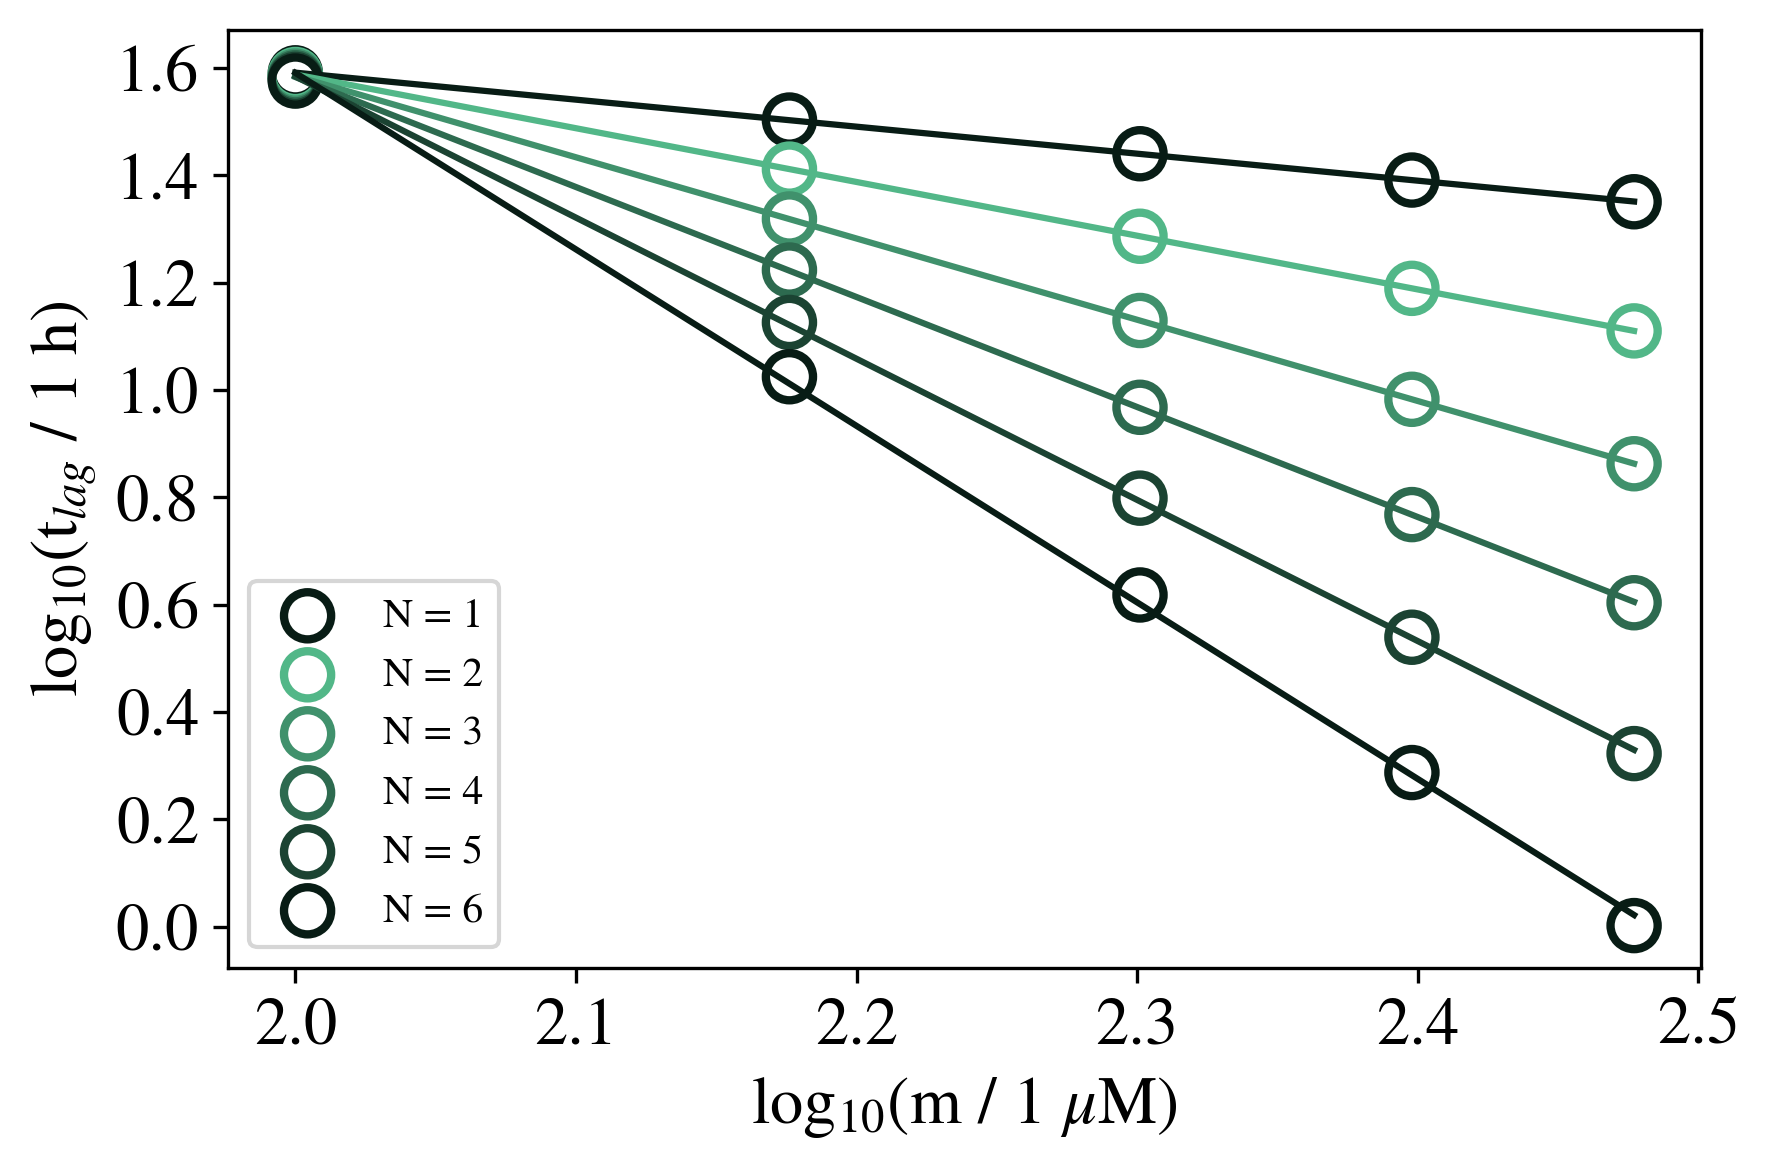

In [37]:
c = 1
K_cap = 1
k_frag = 0
elong_N_th_dict = dict()
calculate_regime_series("th_kin_elong", "th_slope_elong", elong_N_th_dict)

# Elongation regime with capping

R^2 1.0
R^2 precise 1.0
N 1
slope -0.25
N_th 1.25
lag times precise [38.976 35.204 32.724 30.9   29.464]
lag time approx [38.976 35.204 32.724 30.9   29.464]
R^2 1.0
R^2 precise 1.0
N 2
slope -0.76
N_th 1.76
lag times precise [38.7   28.496 22.928 19.368 16.872]
lag time approx [38.7   28.496 22.928 19.368 16.872]
R^2 1.0
R^2 precise 1.0
N 3
slope -1.27
N_th 2.55
lag times precise [38.428 22.976 15.924 11.972  9.472]
lag time approx [38.428 22.976 15.924 11.972  9.472]
R^2 1.0
R^2 precise 1.0
N 4
slope -1.82
N_th 3.65
lag times precise [38.156 18.428 10.916  7.232  5.14 ]
lag time approx [38.156 18.428 10.916  7.232  5.14 ]
R^2 0.99
R^2 precise 1.0
N 5
slope -2.43
N_th 4.86
lag times precise [37.888 14.68   7.336  4.196  2.612]
lag time approx [37.888 14.68   7.336  4.196  2.612]
R^2 0.98
R^2 precise 1.0
N 6
slope -3.13
N_th 6.27
lag times precise [37.62  11.592  4.78   2.28   1.184]
lag time approx [37.62  11.592  4.78   2.28   1.184]


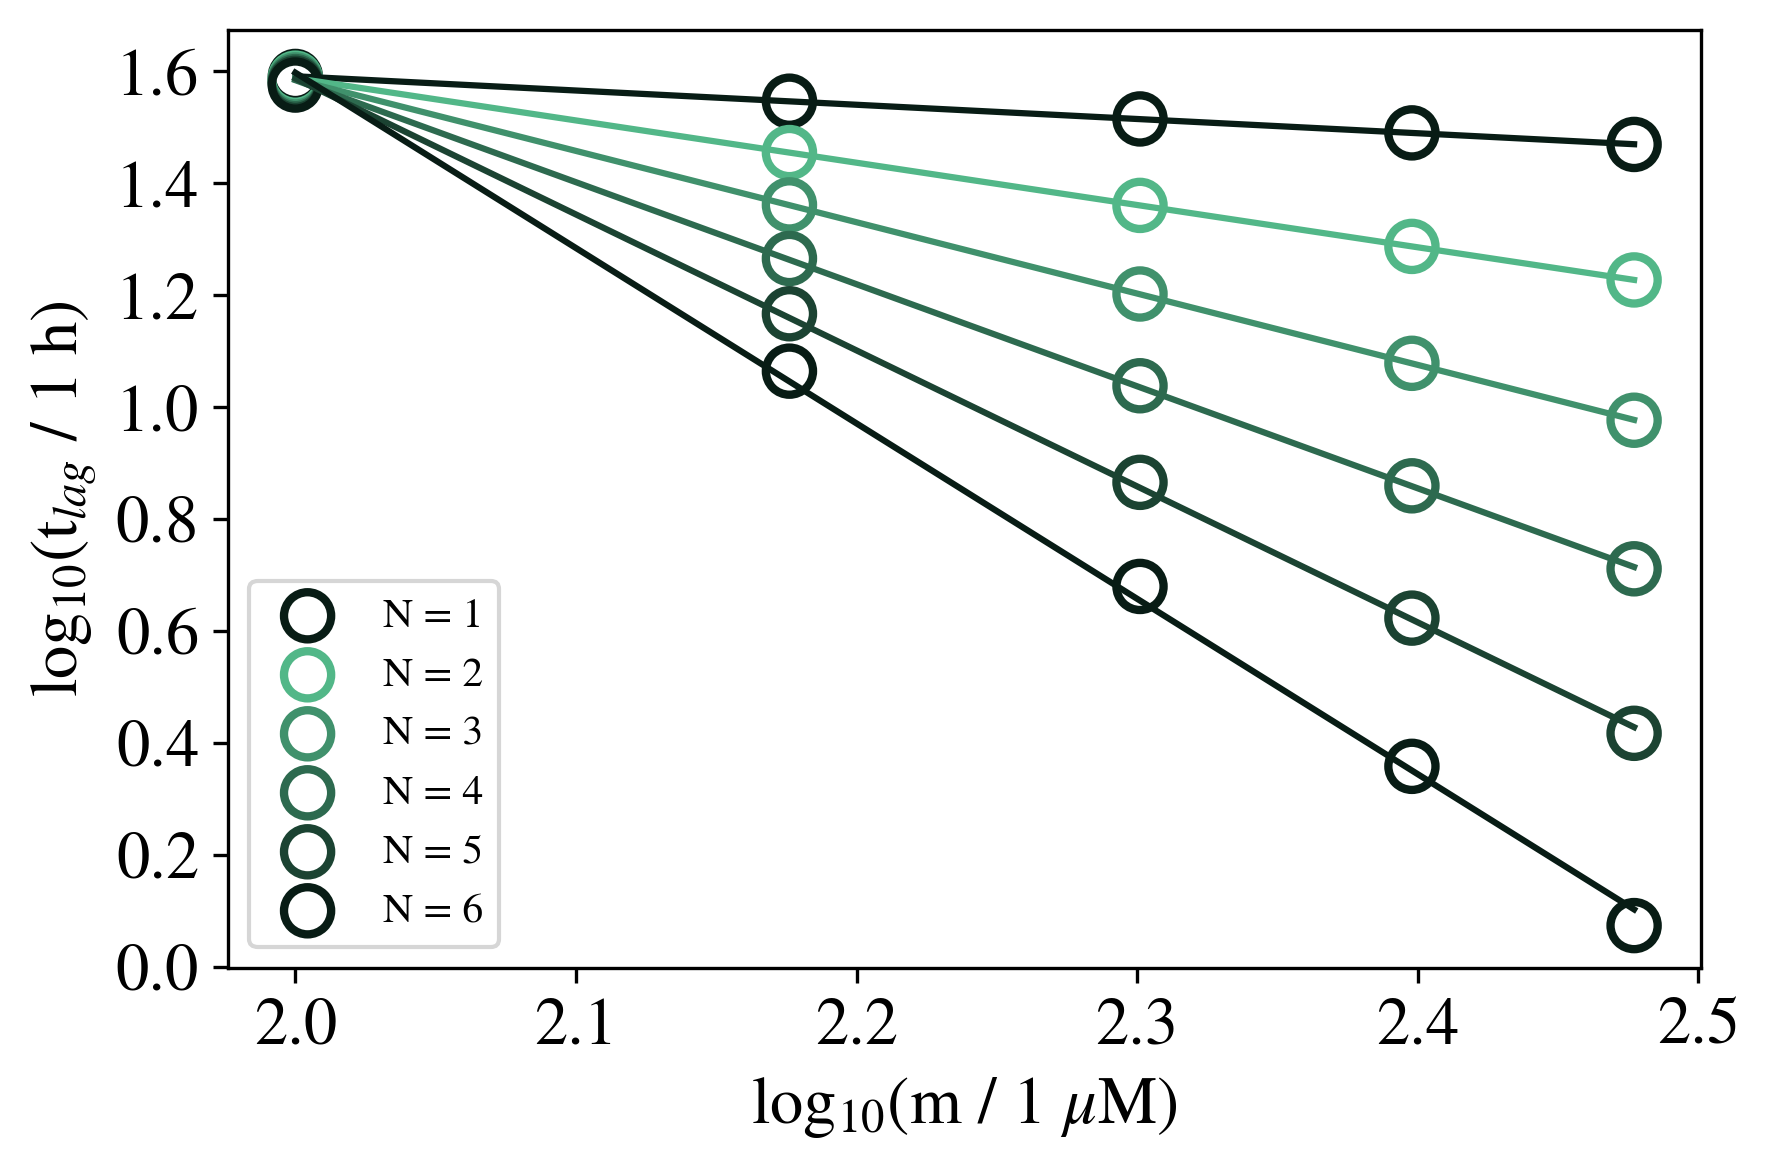

In [38]:
c = 2
K_cap = 10**4
k_frag = 0
elong_cap_N_th_dict = dict()
calculate_regime_series("th_kin_elong_cap", "th_slope_elong_cap", elong_cap_N_th_dict)

# Fragmentation regime

R^2 1.0
R^2 precise 1.0
N 1
slope -0.18
N_th 1.18
lag times precise [8.344 7.792 7.4   7.1   6.852]
lag time approx [8.344 7.792 7.4   7.1   6.852]
R^2 1.0
R^2 precise 1.0
N 2
slope -0.39
N_th 1.39
lag times precise [8.34  7.232 6.46  5.872 5.4  ]
lag time approx [8.34  7.232 6.46  5.872 5.4  ]
R^2 1.0
R^2 precise 0.99
N 3
slope -0.66
N_th 1.66
lag times precise [8.336 6.68  5.536 4.684 4.024]
lag time approx [8.336 6.68  5.536 4.684 4.024]
R^2 1.0
R^2 precise 0.99
N 4
slope -0.99
N_th 1.99
lag times precise [8.332 6.124 4.628 3.564 2.784]
lag time approx [8.332 6.124 4.628 3.564 2.784]
R^2 1.0
R^2 precise 0.98
N 5
slope -1.42
N_th 2.83
lag times precise [8.328 5.568 3.748 2.532 1.732]
lag time approx [8.328 5.568 3.748 2.532 1.732]
R^2 0.99
R^2 precise 0.97
N 6
slope -1.97
N_th 3.95
lag times precise [8.324 5.012 2.904 1.64  0.928]
lag time approx [8.324 5.012 2.904 1.64  0.928]


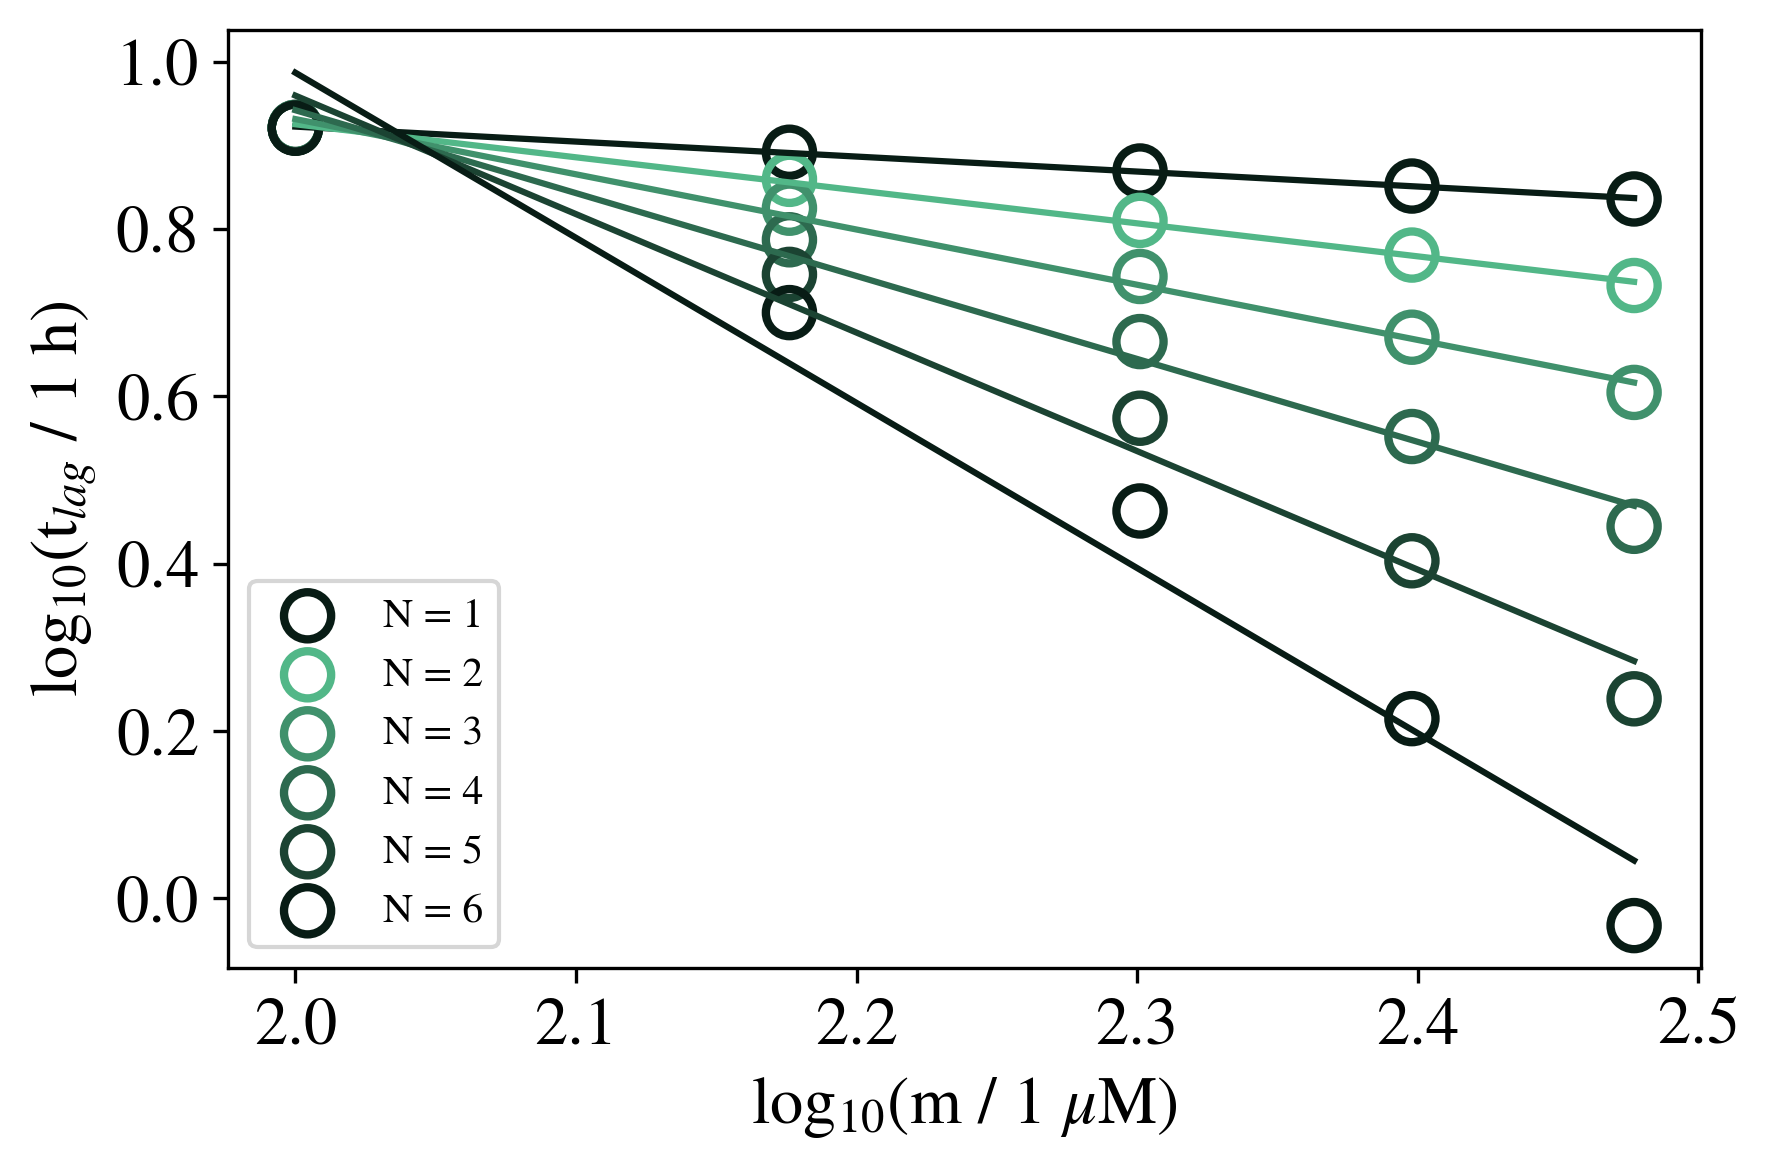

In [39]:
c = 1
K_cap = 1
k_frag = 10**(-4)
frag_N_th_dict = dict()
calculate_regime_series("th_kin_frag", "th_slope_frag", frag_N_th_dict)

# Plot calculated nuclei sizes

###
1 -> 1.5
2 -> 2.0
3 -> 3.03
4 -> 4.1
5 -> 5.26
6 -> 6.58
###
1 -> 1.25
2 -> 1.76
3 -> 2.55
4 -> 3.65
5 -> 4.86
6 -> 6.27
###
1 -> 1.18
2 -> 1.39
3 -> 1.66
4 -> 1.99
5 -> 2.83
6 -> 3.95


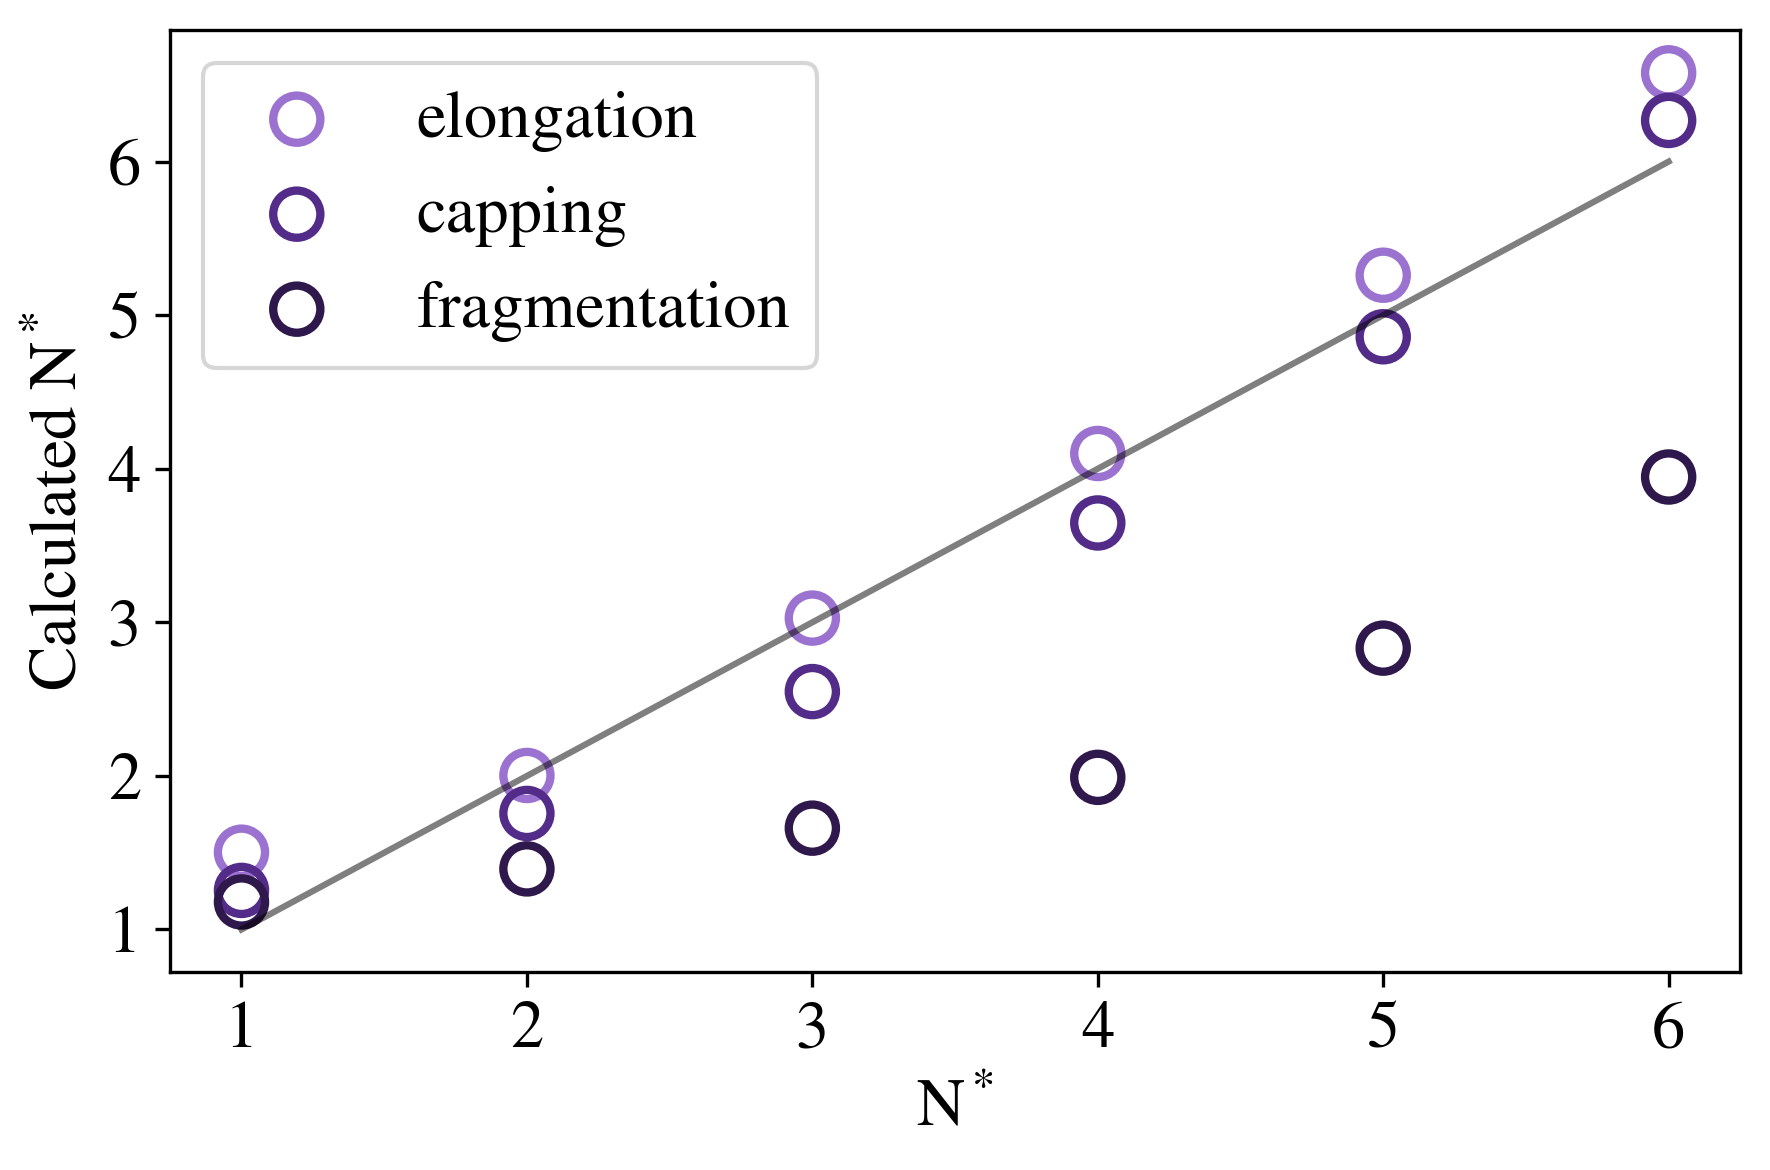

In [42]:
for N_dict in [(elong_N_th_dict, "#9b72cf", "elongation"),
               (elong_cap_N_th_dict, "#532b88", "capping"),
               (frag_N_th_dict, "#2f184b", "fragmentation")]:
    N_list, N_calc_list = [], []

    print("###")
    
    for N in set(N_dict[0].keys()):
        N_list.append(N)
        N_calc_list.append(N_dict[0][N])
        print(N, "->", round(N_dict[0][N], 2))

    plot.scatter(N_list, N_calc_list, label=N_dict[2],
                 color="none", edgecolor=N_dict[1], linewidth=2, s=128)

plot.plot(N_list, N_list, color="black", alpha=0.5)
plot.locator_params(axis="x", nbins=6)
plot.locator_params(axis="y", nbins=12)
plot.xticks(fontsize=16)
plot.yticks(fontsize=16)
plot.xlabel(r"N$^*$", fontsize=16)
plot.ylabel(r"Calculated N$^*$", fontsize=16)
plot.legend(fontsize=16)
plot.tight_layout()
plot.savefig("fig/th_N.png")
plot.show()

# Building plots for experimental data

### PEPTIDE ###
A$\beta$40
###############
R^2_1 1.0
slope_1 -0.44 
    N_tan_1 1.88 
    N_elong_1 1.44 
    N_cap_1 1.44 
    N_frag_1 2.19
R^2_2 0.99
slope_2 -0.42 
    N_tan_2 1.85 
    N_elong_2 1.42 
    N_cap_2 1.42 
    N_frag_2 2.12
R^2 0.88
slope -0.26 
    N_tan 1.51 
    N_elong 1.26 
    N_cap 1.26 
    N_frag 1.36 
   

### PEPTIDE ###
A$\beta$40
###############
R^2 1.0
No appropriate nucleus size found, try other model.
slope -0.13 
    N_tan 1.26 
    N_elong 1.13 
    N_cap 1.13 
    N_frag 0 
   

### PEPTIDE ###
insulin
###############
R^2 0.95
slope -0.7 
    N_tan 2.39 
    N_elong 1.7 
    N_cap 1.89 
    N_frag 3.11 
   

### PEPTIDE ###
$\alpha$-syn
###############
R^2_1 1.0
slope_1 -0.26 
    N_tan_1 1.53 
    N_elong_1 1.26 
    N_cap_1 1.26 
    N_frag_1 1.4
R^2_2 1.0
slope_2 -1.4 
    N_tan_2 3.8 
    N_elong_2 2.8 
    N_cap_2 3.3 
    N_frag_2 4.96
R^2 0.85
slope -0.75 
    N_tan 2.51 
    N_elong 1.75 
    N_cap 2.01 
    N_frag 3.29 
   

### PEPTIDE ###

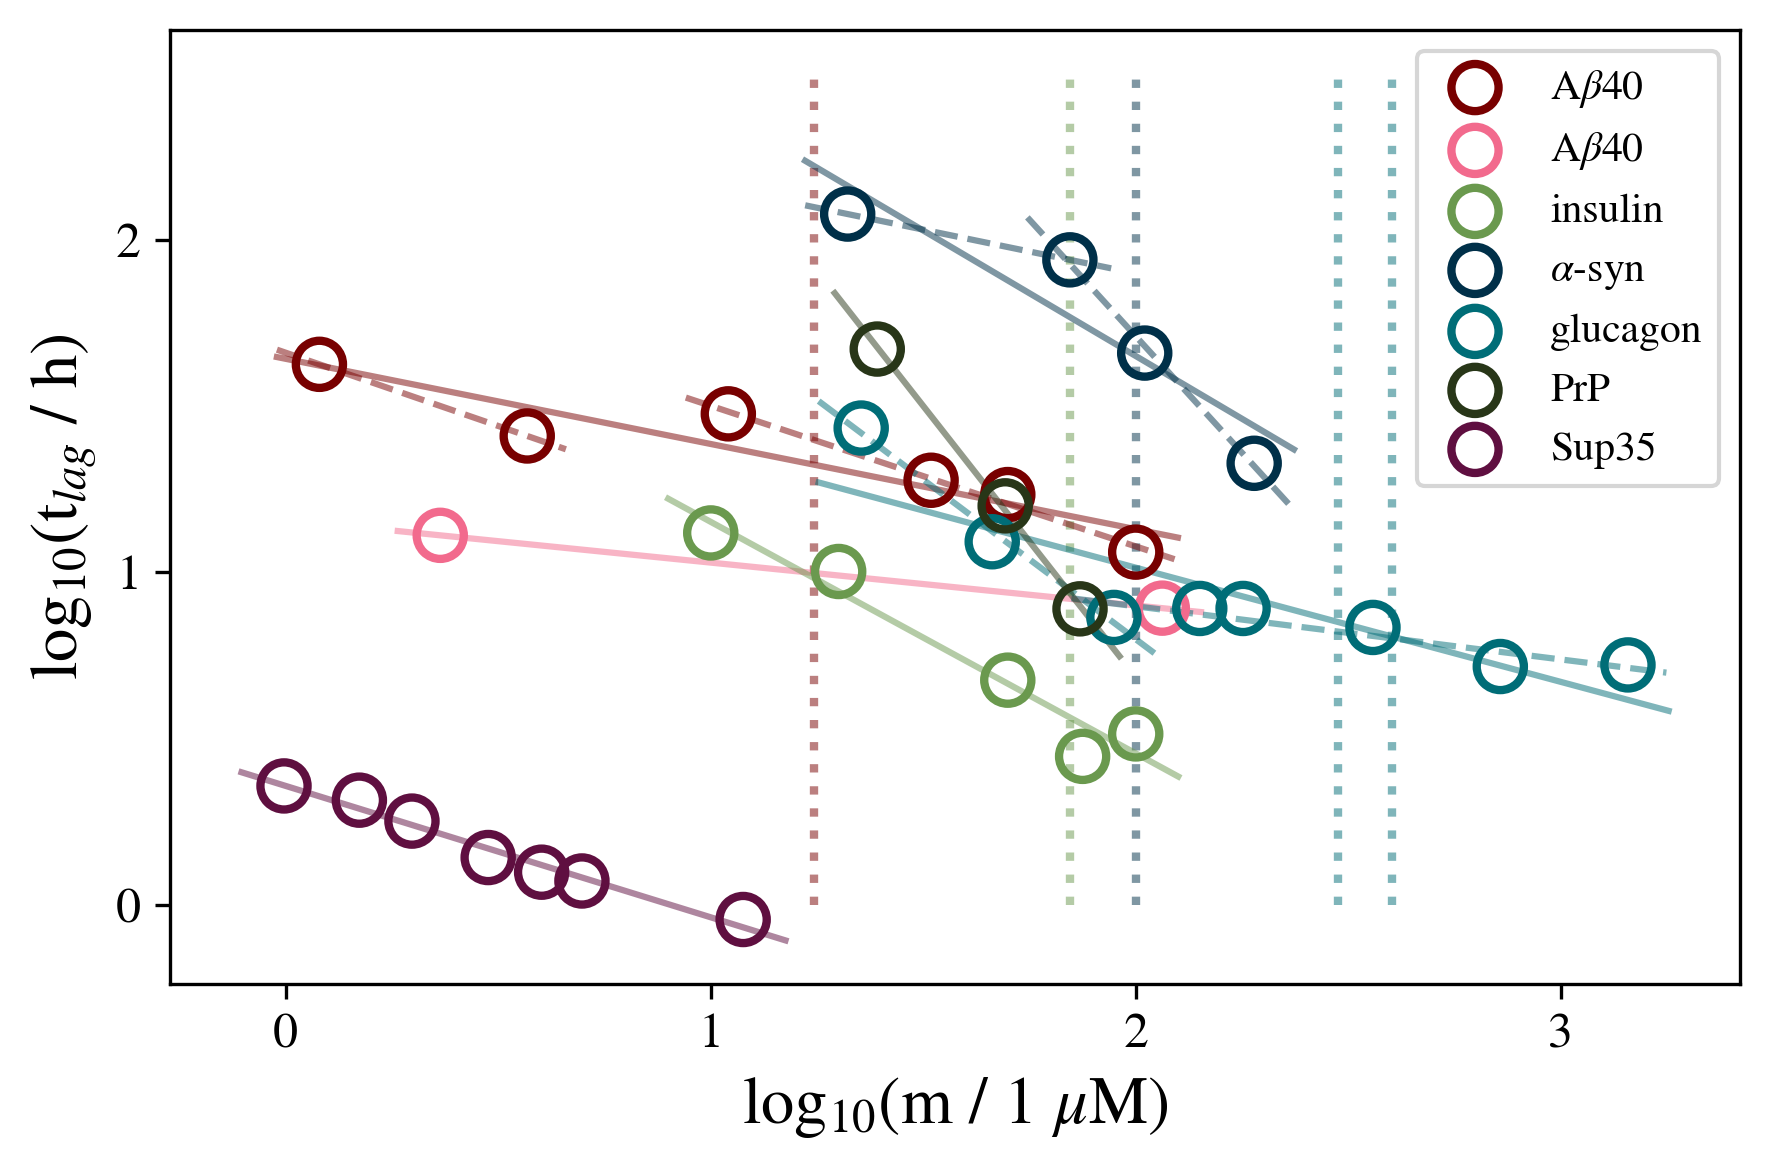

In [21]:
def get_N_tan(slope):
    return -2 * slope + 1


def get_N_elong_cap(slope, c):
    return max(-2 * slope + 1 - 1 / c, 1 - slope)


def get_N_inter(s, s_dict):
    for n in set(s_dict.keys()):
        if n > 5:
            continue

        s_n = abs(s_dict[n])
        s = abs(s)
        s_n_next = abs(s_dict[n+1])
        
        if not (s_n <= s <= s_n_next):
            continue

        w_n = s_n_next - s
        w_n_next = s - s_n
        
        return (n * w_n + (n+1) * w_n_next) / (w_n + w_n_next)

    print("No appropriate nucleus size found, try other model.")
    return 0


s_dict_elong = {
    1: -0.5,
    2: -1.0,
    3: -1.51,
    4: -2.05,
    5: -2.63,
    6: -3.29
}

s_dict_cap = {
    1: -0.26,
    2: -0.75,
    3: -1.25,
    4: -1.76,
    5: -2.27,
    6: -2.78
}

s_dict_frag = {
    1: -0.18,
    2: -0.39,
    3: -0.66,
    4: -0.99,
    5: -1.42,
    6: -1.97
}


def build_peptide(m_list, t_lag_list, label, color, split=None):
    ln_m_arr = np.log(np.array(m_list)) / np.log(10)
    ln_t_lag_arr = np.log(np.array(t_lag_list)) / np.log(10)

    regr = stats.linregress(ln_m_arr, ln_t_lag_arr)
    print("### PEPTIDE ###")
    print(label)
    print("###############")
    slope, intercept = regr.slope, regr.intercept

    if split is not None:
        m_1_sub, m_2_sub, m_1_sup, m_2_sup = \
            split[0][0]-1, split[0][1], split[1][0]-1, split[1][1]
        regr_sub = stats.linregress(ln_m_arr[m_1_sub:m_2_sub],
                                    ln_t_lag_arr[m_1_sub:m_2_sub])
        slope_sub = regr_sub.slope
        regr_sup = stats.linregress(ln_m_arr[m_1_sup:m_2_sup],
                                    ln_t_lag_arr[m_1_sup:m_2_sup])
        slope_sup = regr_sup.slope

        print("R^2_1", round(regr_sub.rvalue**2, 2))
        print("slope_1", round(slope_sub, 2), "\n   ",
              "N_tan_1", round(get_N_tan(slope_sub), 2), "\n   ",
              "N_elong_1", round(get_N_elong_cap(slope_sub, 1), 2), "\n   ",
              "N_cap_1", round(get_N_elong_cap(slope_sub, 2), 2), "\n   ",
              "N_frag_1", round(get_N_inter(slope_sub, s_dict_frag), 2))

        print("R^2_2", round(regr_sup.rvalue**2, 2))
        print("slope_2", round(slope_sup, 2), "\n   ",
              "N_tan_2", round(get_N_tan(slope_sup), 2), "\n   ",
              "N_elong_2", round(get_N_elong_cap(slope_sup, 1), 2), "\n   ",
              "N_cap_2", round(get_N_elong_cap(slope_sup, 2), 2), "\n   ",
              "N_frag_2", round(get_N_inter(slope_sup, s_dict_frag), 2))

        ln_m_regr_list, ln_t_lag_regr_list = [], []

        for ln_m in np.arange(np.min(ln_m_arr[m_1_sub:m_2_sub])-0.1,
                              np.max(ln_m_arr[m_1_sub:m_2_sub])+0.1,
                              0.01):
            ln_m_regr_list.append(ln_m)
            ln_t_lag_regr_list.append(regr_sub.intercept + slope_sub * ln_m)

        plot.plot(ln_m_regr_list, ln_t_lag_regr_list,
                  color=color, alpha=0.5, zorder=-1, linestyle="--")

        ln_m_regr_list, ln_t_lag_regr_list = [], []

        for ln_m in np.arange(np.min(ln_m_arr[m_1_sup:m_2_sup])-0.1,
                              np.max(ln_m_arr[m_1_sup:m_2_sup])+0.1,
                              0.01):
            ln_m_regr_list.append(ln_m)
            ln_t_lag_regr_list.append(regr_sup.intercept + slope_sup * ln_m)

        plot.plot(ln_m_regr_list, ln_t_lag_regr_list, color=color,
                  alpha=0.5, zorder=-1, linestyle="--")

    ln_m_regr_list, ln_t_lag_regr_list = [], []

    for ln_m in np.arange(np.min(ln_m_arr)-0.1, np.max(ln_m_arr)+0.1, 0.01):
        ln_m_regr_list.append(ln_m)
        ln_t_lag_regr_list.append(intercept + slope * ln_m)

    plot.plot(ln_m_regr_list, ln_t_lag_regr_list,
              color=color, alpha=0.5, zorder=-1)

    plot.scatter(ln_m_arr, ln_t_lag_arr, s=128, color="none",
                 linewidth=2, edgecolor=color, zorder=0, label=label)

    print("R^2", round(regr.rvalue**2, 2))
    print("slope", round(slope, 2), "\n   ",
          "N_tan", round(get_N_tan(slope), 2), "\n   ",
          "N_elong", round(get_N_elong_cap(slope, 1), 2), "\n   ",
          "N_cap", round(get_N_elong_cap(slope, 2), 2), "\n   ",
          "N_frag", round(get_N_inter(slope, s_dict_frag), 2), "\n   ")
    print()


fig, ax = plot.subplots()
data_file = open("res/data.txt", "w")

# 2014 Alzheimer prot mut / benilova2014alzheimer
amyl_beta_m_list = [100, 50, 33, 11, 3.7, 1.2]
amyl_beta_m_list.reverse()
amyl_beta_t_list = [11.49606, 17.12454, 18.90861, 29.94412, 25.69273, 42.18861]
amyl_beta_t_list.reverse()

data_file.write("amyloid beta 40\n")
for i in range(len(amyl_beta_m_list)):
    data_file.write(str(amyl_beta_m_list[i]) + " " + str(amyl_beta_t_list[i]) + "\n")
    
build_peptide(amyl_beta_m_list, amyl_beta_t_list,
              r"A$\beta$40", "#780000",
              split=((1, 2), (3, 6)))

plot.vlines(x=np.log(17.5) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#780000", alpha=0.5)

# 2005 stock nucl / hortschansky2005aggregation
amyl_beta_m_list = [0.01, 0.5]
amyl_beta_t_list = [12.914842332448384, 7.80115902398663]

data_file.write("amyloid beta 40\n")
for i in range(len(amyl_beta_m_list)):
    data_file.write(str(amyl_beta_m_list[i]) + " " + str(amyl_beta_t_list[i]) + "\n")

build_peptide(np.array(amyl_beta_m_list) * 10**6 / 4330,
              amyl_beta_t_list,
              r"A$\beta$40", "#f26a8d")

# 2017 insulin low mol weight / mawhinney2017elucidation
insulin_m_list = [10, 20, 50, 75, 100]
insulin_t_list = [13.12983, 10.05408, 4.73856, 2.79601, 3.26629]

data_file.write("insulin\n")
for i in range(len(insulin_m_list)):
    data_file.write(str(insulin_m_list[i]) + " " + str(insulin_t_list[i]) + "\n")

build_peptide(insulin_m_list, insulin_t_list,
              "insulin", "#6a994e")

plot.vlines(x=np.log(70) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#6a994e", alpha=0.5)

# 2001 aggr / uversky2001metal
alpha_syn_m_list = [190, 105, 70, 21]
alpha_syn_m_list.reverse()
alpha_syn_t_list = [21.26436, 45.60487, 86.95666, 119.38926]
alpha_syn_t_list.reverse()

data_file.write("alpha-synuclein\n")
for i in range(len(alpha_syn_m_list)):
    data_file.write(str(alpha_syn_m_list[i]) + " " + str(alpha_syn_t_list[i]) + "\n")

build_peptide(alpha_syn_m_list, alpha_syn_t_list,
              r"$\alpha$-syn", "#003049",
              ((1, 2), (2, 4)))

plot.vlines(x=np.log(100) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#003049", alpha=0.5)

# 2010 amyl glucagon fibr / pedersen2010nature
glucagon_m_list = [0.07885698277362686, 0.16038834323050954, 0.3101510016911516, 0.4937606601091607, 0.6244037279870213, 1.2621129501461767, 5.02475666835675, 2.516166466611133]
glucagon_t_list = [27.140770209207215, 12.352425242410687, 7.315527254738861, 7.784049571140164, 7.784049571140164, 6.825437596331329, 5.266058793357991,  5.207599061432788]

data_file.write("glucagon\n")
for i in range(len(glucagon_m_list)):
    data_file.write(str(glucagon_m_list[i]) + " " + str(glucagon_t_list[i]) + "\n")

build_peptide(np.array(glucagon_m_list) * 10**6 / 3490,
              glucagon_t_list,
              "glucagon", "#006d77",
              split=((1,3),(3,8)))

# 2011 dynamic mult struc / alvarez2011dynamics
PrP_m_list = [0.4, 0.8, 1.2]
PrP_t_list = [46.894409937888206, 15.838509316770185, 7.763975155279496]

data_file.write("PrP\n")
for i in range(len(PrP_m_list)):
    data_file.write(str(PrP_m_list[i]) + " " + str(PrP_t_list[i]) + "\n")

build_peptide(np.array(PrP_m_list) / 16227 * 10**6,
              PrP_t_list,
              "PrP", "#283618")

# 2004 Sup35 / collins2004mechanism
Sup35_m_list = [0.9905497407751119, 1.4900329635645067, 1.9811037337930752, 2.994254147511826, 4.0000171712625425, 4.976307588327792, 11.92034046584007]
Sup35_t_list = [136.7119931021745, 123.88085108976797, 107.16659295874662, 83.2790087872571, 75.2444059529987, 70.80067856843452, 54.227435693730705]

data_file.write("Sup35\n")
for i in range(len(Sup35_m_list)):
    data_file.write(str(Sup35_m_list[i]) + " " + str(Sup35_t_list[i]) + "\n")

build_peptide(Sup35_m_list,
              np.array(Sup35_t_list) / 60,
              "Sup35", "#5f0f40")

plot.vlines(x=np.log(300) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#006d77", alpha=0.5)
plot.vlines(x=np.log(400) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#006d77", alpha=0.5)

plot.xlabel(r"log$_{10}$(m / 1 $\mu$M)", fontsize=16)
plot.ylabel(r"log$_{10}$(t$_{lag}$ / h)", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=5)
plot.legend()
plot.tight_layout()
plot.savefig("fig/m_t_lag.png")

data_file.close()

# Extracting structural properties of the peptides

In [22]:
names = ["1aml", "3i40", "1xq8", "1gcn", "6du9", "fold_prion", "Sup35"]

for name in names:
    f = open("struc/" + name + ".dssp")
    lines = f.readlines()
    f.close()

    flag = False
    cnt, cnt_hel = 0, 0

    for line in lines:
        tokens = line.split()

        if flag:
            if tokens[1] not in ["!", "!*"]:
                cnt += 1
            if tokens[4] in ["H", "G", "I", "P"]:
                cnt_hel += 1

        if tokens[0] == "#":
            flag = True

    print(name, cnt, cnt_hel, round(cnt_hel / cnt * 100))

1aml 40 15 38
3i40 51 25 49
1xq8 140 83 59
1gcn 29 14 48
6du9 91 55 60
fold_prion 141 67 48
Sup35 254 26 10


# Graphical representation of properties

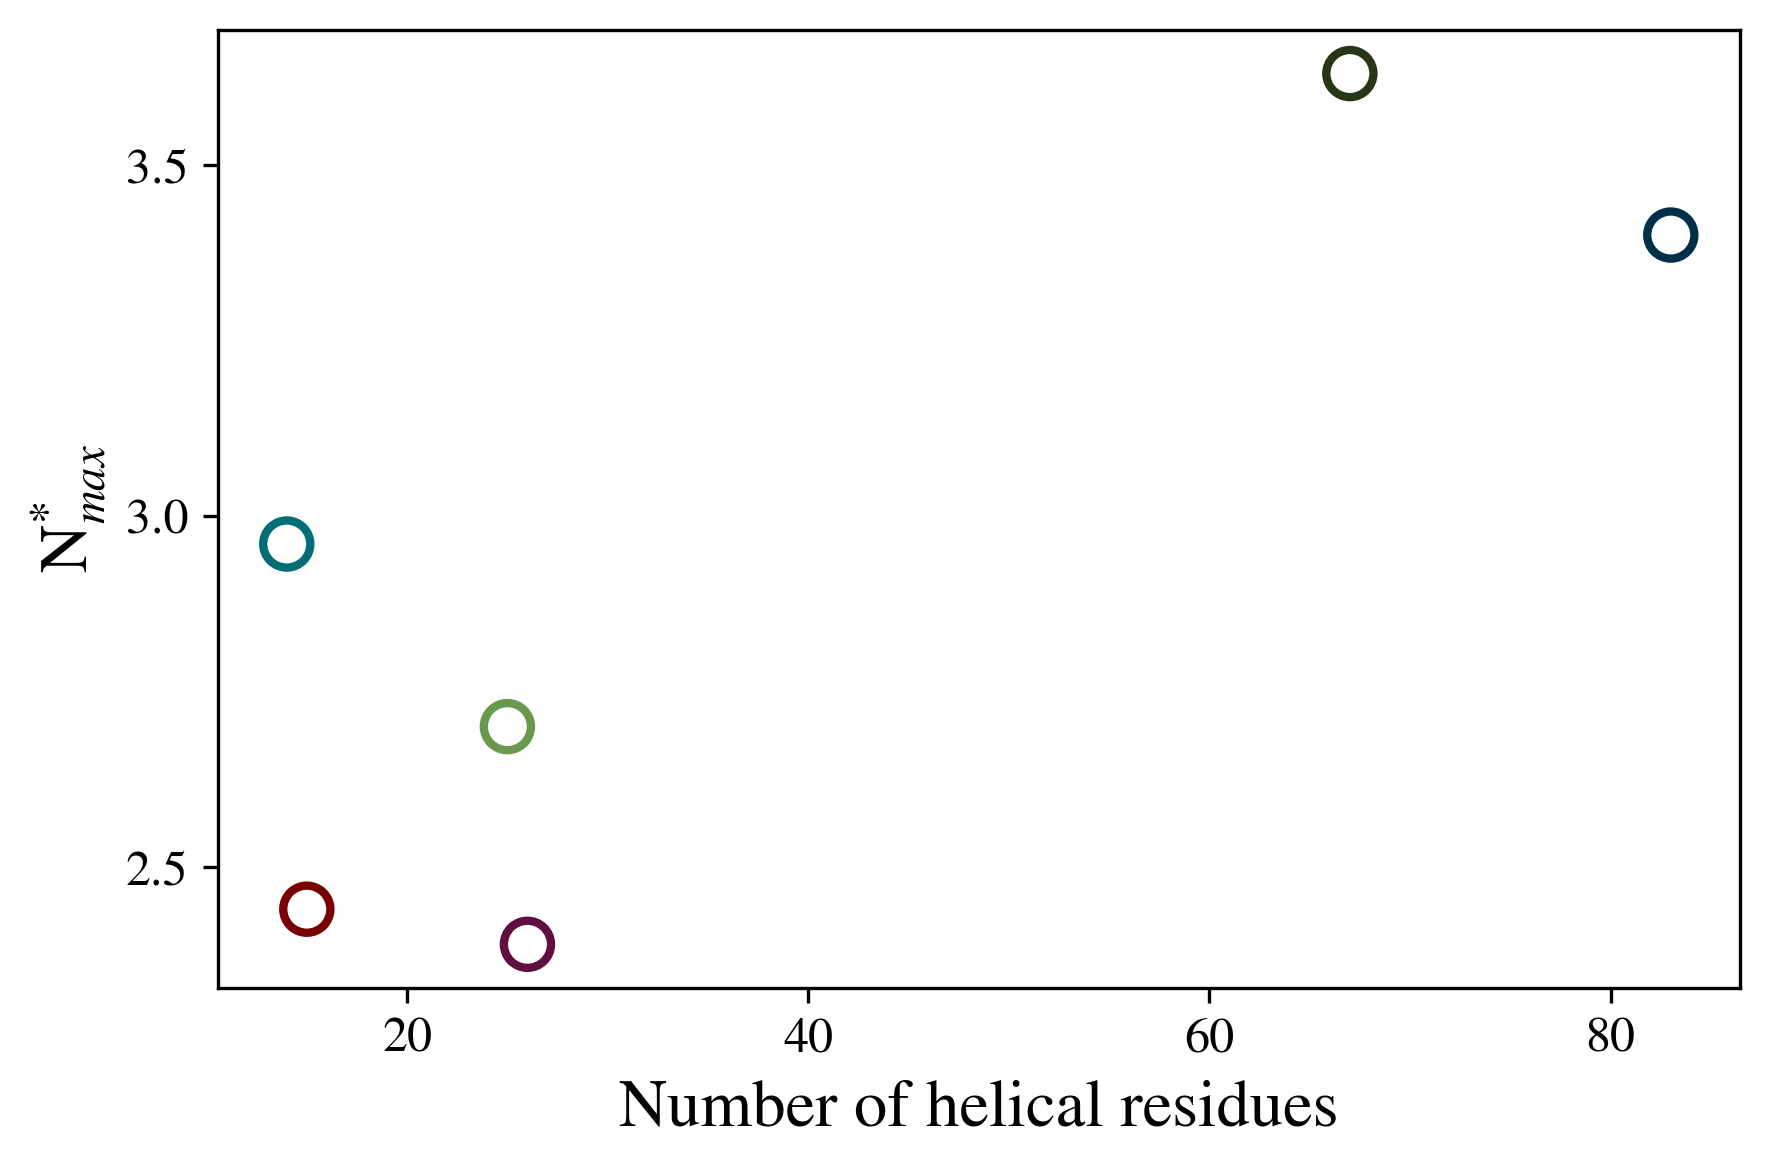

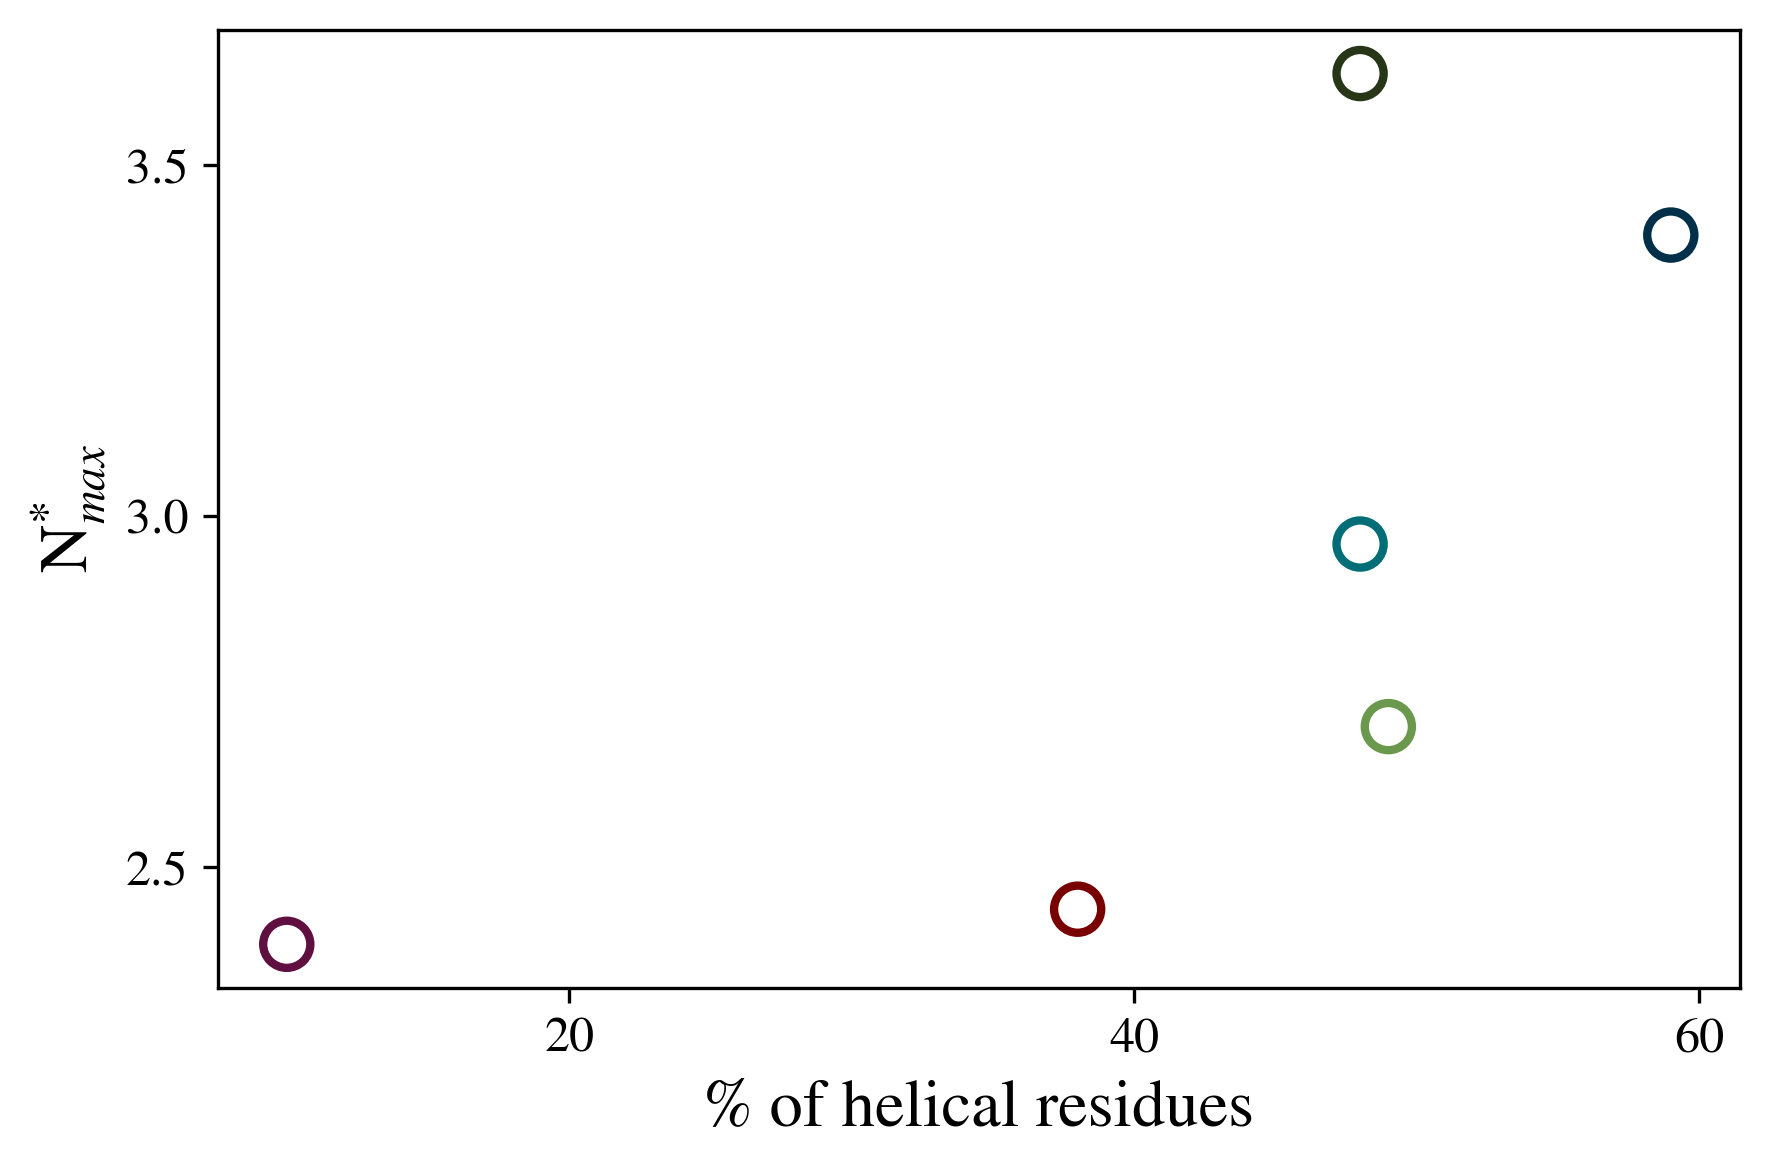

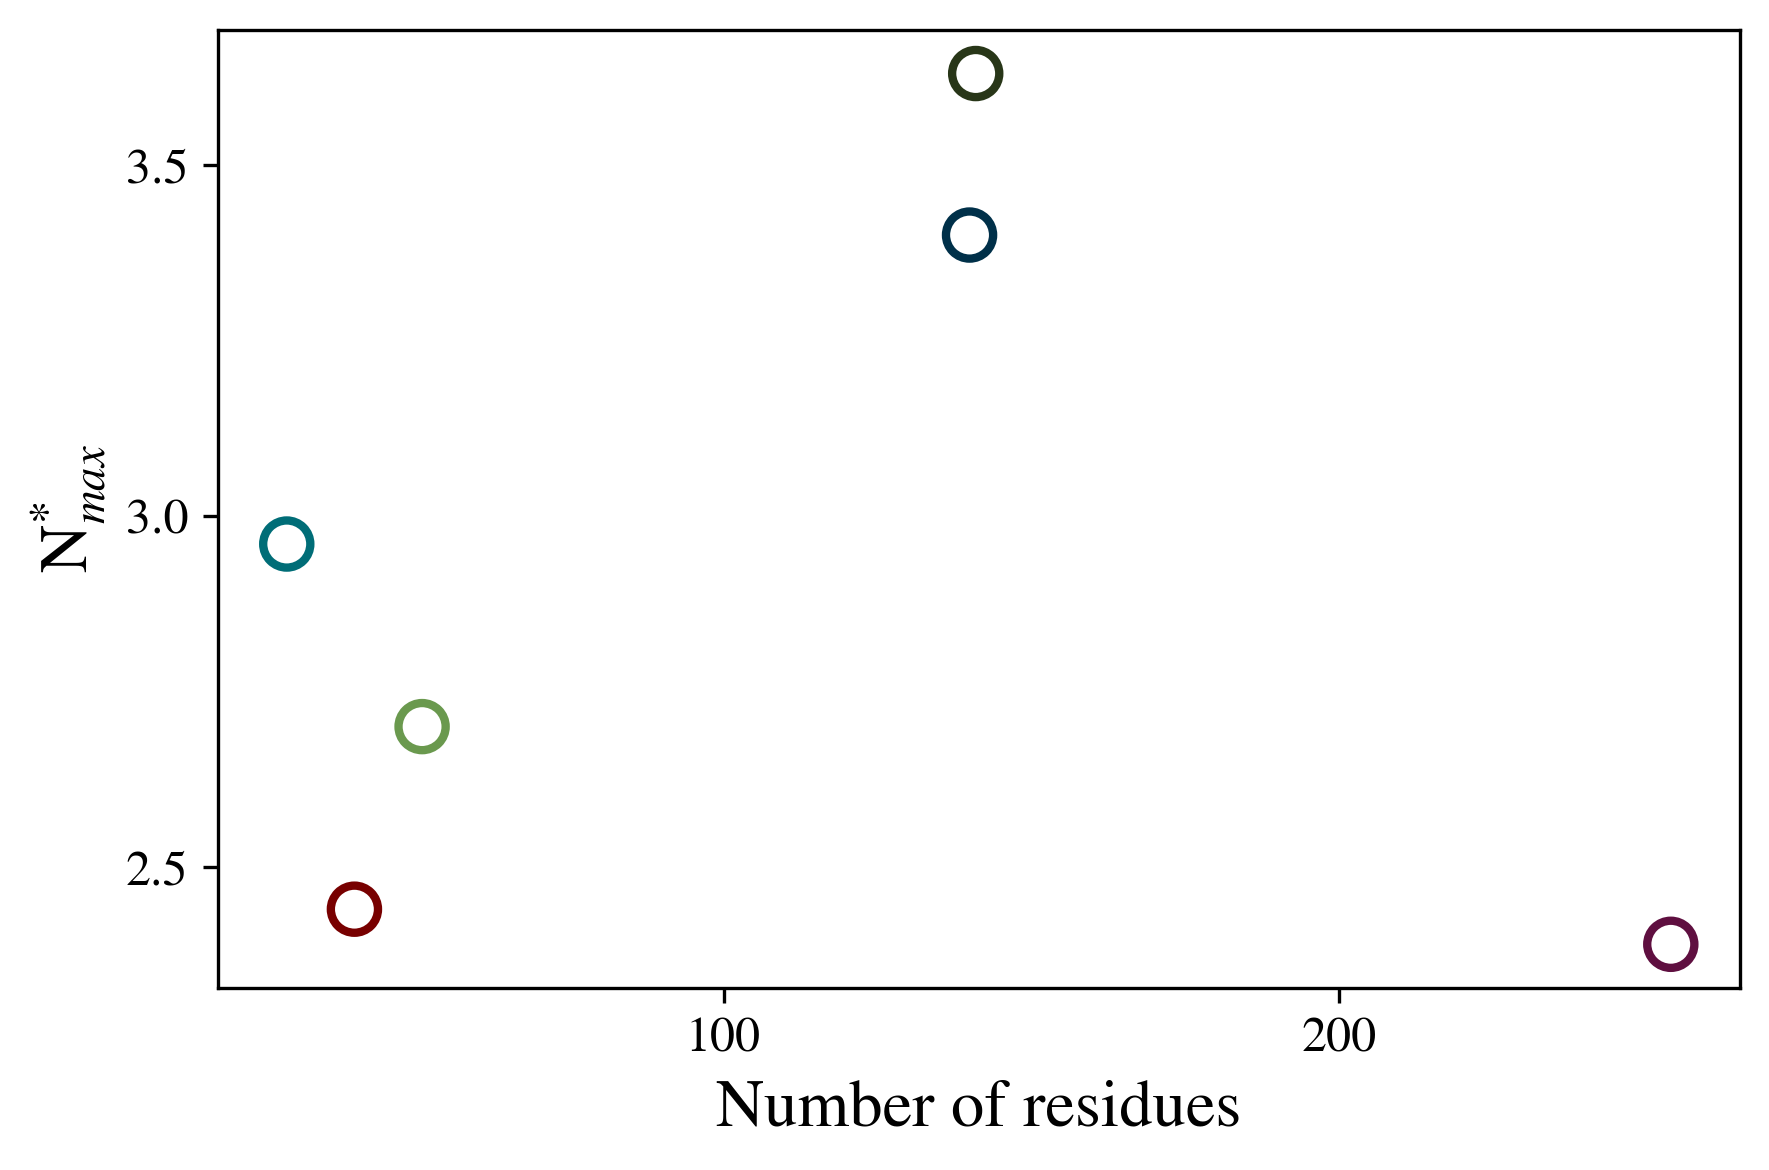

In [23]:
len_cnt = [40, 51, 140, 29, 141, 254]
hel_cnt = [15, 25, 83, 14, 67, 26]
hel_fra = [38, 49, 59, 48, 48, 10]
max_nuc = [2.44, 2.70, 3.4, 2.96, 3.63, 2.39]
colors = ["#780000", "#6a994e", "#003049", "#006d77", "#283618", "#5f0f40"]

plot.scatter(hel_cnt, max_nuc, s=128, color="none",
             linewidth=2, edgecolor=colors, zorder=0,)
plot.xlabel("Number of helical residues", fontsize=16)
plot.ylabel(r"N$^{*}_{max}$", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=5)
plot.tight_layout()
plot.show()

plot.scatter(hel_fra, max_nuc, s=128, color="none",
             linewidth=2, edgecolor=colors, zorder=0,)
plot.xlabel("% of helical residues", fontsize=16)
plot.ylabel(r"N$^{*}_{max}$", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=5)
plot.tight_layout()
plot.show()

plot.scatter(len_cnt, max_nuc, s=128, color="none",
             linewidth=2, edgecolor=colors, zorder=0,)
plot.xlabel("Number of residues", fontsize=16)
plot.ylabel(r"N$^{*}_{max}$", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=5)
plot.tight_layout()
plot.show()

# (C) Egor Vasilenko, Dmitry Ivankov, 2025